# Business Context

Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds in a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts.

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

# Business Challange

In this project, I was challenged to predict in which country a new user will make his or her first booking.


# Business Understanding

- Business model:
     Marketplace -> Connecting people that offer accommodation, to the person who's looking for accommodation.
    
    
- Model Offer:
     People offering them property temporarily.
     
- Metrics:  Portfolio Size, Portfolio diversity/density.

- Demand: How many people are looking for accommodation; 

    - User number.
    - LTV ( Lifetime Value)
    - CAC ( Client Acquisition Cost )
    
    - Gross Revenue =  ( fee * number of clients ) - CAC

# Solution Planning

- Prediction model of the first destination of a new user
- Prediction saved in a database table.
- API:

    - Imput: Users and their characteristics;
    - output: Users and their characteristics with the destination prediction.

# 0.1 Imports

In [22]:
import random 
import warnings
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot    as plt

from scipy import stats as ss
from keras import layers as l
from keras import models as ml
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from scikitplot import metrics as mt

from IPython.core.display        import HTML

## 0.01 Helper Functions

In [23]:
def jupyter_settings(): 
    %matplotlib inline 
    #%matplotlib notebook
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
     
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    
    sns.set()

%matplotlib inline 
%matplotlib notebook

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24


display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option ('display.expand_frame_repr', False)

sns.set()

jupyter_settings()

# ===============================================
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm)[0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1) 
    rcorr = r - (r-1)**2/(n-1) 

    return  np.sqrt( (chi2corr/n) / (min ( kcorr-1, rcorr-1) ) )

#=================================================


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0  Data Description

## 1.1 Loading data

In [24]:
df1 = pd.read_csv('/Users/adriele/Documents/repos/pa001/dataset/train_users.csv')

df_sessions = pd.read_csv('/Users/adriele/Documents/repos/pa001/dataset/sessions.csv')


## 1.2 Data Dimensions

In [25]:
print( 'Number of Cols {}'.format( df1.shape[1] ) )
print( 'Number of Rows {}'.format( df1.shape[0] ) )


Number of Cols 16
Number of Rows 213451


In [26]:
print( 'Number of Cols {}'.format( df_sessions.shape[1] ) )
print( 'Number of Rows {}'.format( df_sessions.shape[0] ) )



Number of Cols 6
Number of Rows 10567737


## 1.3 Check Na's

In [27]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [28]:
df1['country_destination' ].value_counts( normalize=True )

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [29]:
# removing missing values
#df1 = df1.dropna()
#========================== User ===============================

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# Age
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked

df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ======================= sessions ===============================

# user id 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna() ]

# Action 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna() ]

# action_type 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna() ]

# action_detail 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna() ]

# secs_elapsed 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna() ]



## 1.4 Data Types

In [30]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.5 Change Dtypes

In [31]:
#date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

#date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )


#age
df1['age'] = df1['age'].astype( int )


df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6 Check Balanncing Data

In [32]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7 Descriptive Analysis

### 1.7.1 General

In [33]:
# Users
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64' ] )
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]' ] )
time_attributes = df1.select_dtypes( include=[ 'datetime64[ns]'  ] )

# sessions
num_attributes_sessions = df_sessions.select_dtypes( include=[ 'int64', 'float64' ] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]' ] )
time_attributes_sessions = df_sessions.select_dtypes( include=[ 'datetime64[ns]'  ] )

### 1.7.2 Numerical Users

In [34]:
# Central tendency - Mean, mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispensions- STD, Min, Max, Range, Slkew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
d2 = pd.DataFrame( num_attributes.apply( min) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T


# Concat
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
ct.columns= ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.183142,49.0,49.183142,16.333820,267.655434
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,3.151490,2.287158,3.567794


### 1.7.3 Categorical - User


In [35]:
cat_attributes.drop( 'id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### 1.7.4 Numerical - Sessions

In [36]:
# Central tendency - Mean, mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# dispensions- STD, Min, Max, Range, Slkew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply(lambda x: x.kurtosis() ) ).T


# Concat
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
ct.columns= ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,19961.8251,11.137761,154.84312


### 1.7.4 Categorical - Sessions

In [37]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [38]:
# attrivute list for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list )):
    corr_list = []
    for j in range( len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # Correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ])
        
        # append to list
        corr_list.append( corr )
        
     # Append the correlation list to each ref attributes   
    corr_dict[ ref ] = corr_list

<Axes: >

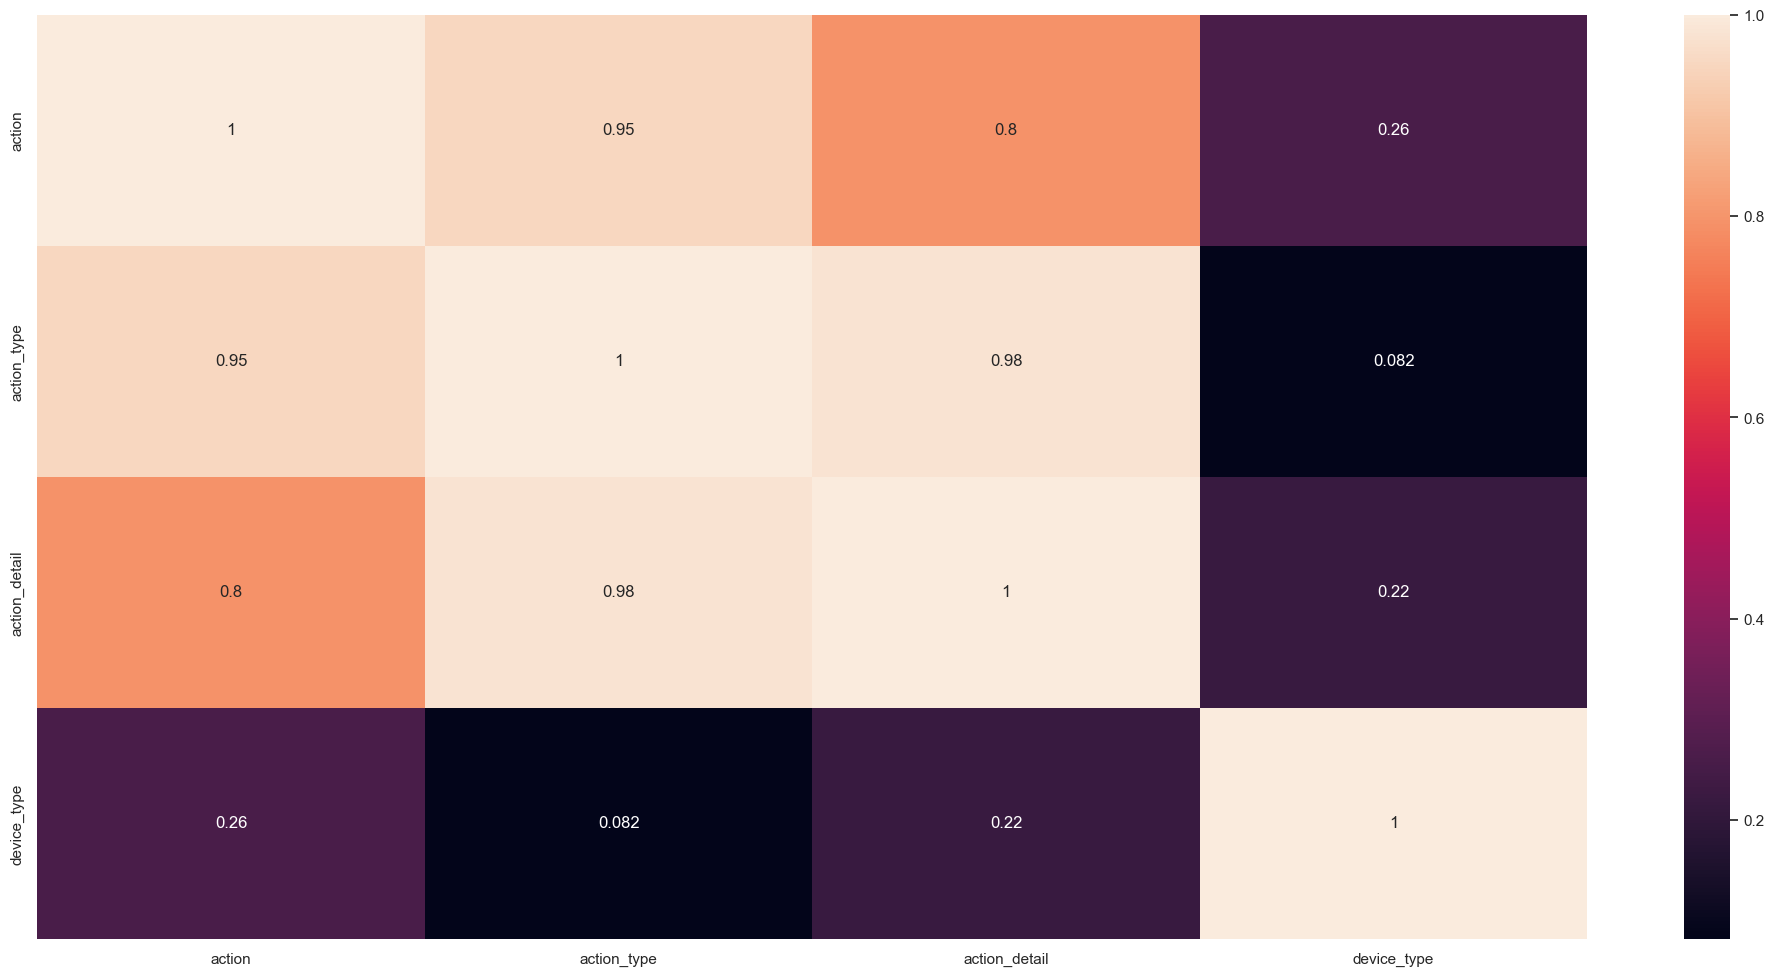

In [43]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 2.0 Data Filtering

In [50]:
df2 = df1.copy()
df2_ses = df_sessions.copy()
df2.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

## 2.1 Creat New Features

In [60]:
# Days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_untill_booking'] = (df2['date_first_booking'] - df2['first_active']).apply( lambda x: x.days )


# Days from first active up to account created
df2['days_from_first_active_untill_account_created'] = (df2['date_account_created'] - df2['first_active']).apply( lambda x: x.days )

# Days from account created  up to first book
df2['days_from_account_created_untill_first_booking'] = (df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )


# ====================   First active ================================
# year of first active
df2['year_first_active'] = df2['first_active'].dt.year

# month of first active
df2['month_first_active'] = df2['first_active'].dt.month

# day of first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week__first_active'] = df2['first_active'].dt.dayofweek

# week of year of first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


# ========================= First Booking ===========================

# year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


# ======================= Account Created ==============================

# year of account created
df2['year_account_created'] = df2['date_account_created'].dt.year

# month of account created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day of account created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week account created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year of account created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear



/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_9685/2767803523.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_9685/2767803523.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_9685/2767803523.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [63]:
df2.shape

(207386, 36)

## 2.2 Columns Selection

# 3.0 Data Filtering

In [64]:
df3 = df2.copy()
df3_ses = df2_ses.copy()

## 3.1 Filtering Row

In [65]:
# Age - There are few people over 120 years old.
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )] 


# secs_elapse - There's no possibility 0 sec elapse on webs
df3_ses = df3_ses[ df3_ses['secs_elapsed'] > 0]

# 4.0 Data Preparation

In [75]:
df4 = df3.copy()


# dammy variable
df4_dummy = pd.get_dummies( df4.drop( ['id', 'country_destination'], axis=1) )

# join Id and Country destination
df4 = pd.concat( [df4[['id', 'country_destination']], df4_dummy], axis=1 )

In [76]:
df4.shape

(207386, 157)

# 5.0  Features Selection

In [77]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active']

df5 = df4.drop(cols_drop, axis=1 )

# 6.0 Machine Learning Model

In [78]:
df6 = df5.copy()

In [79]:
x = df6.drop( 'country_destination', axis=1 )
y = df6[ 'country_destination' ].copy()

In [80]:
# split dataset into to training and test
X_train, X_test, y_train, y_test = ms.train_test_split( x, y, test_size=0.2, random_state = 42 )

In [81]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

## 6.1 Baseline Model

In [82]:
import random


country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]

country_destination_weight = df1['country_destination'].value_counts( normalize=True ).sort_index()

yhat_random = random.choices( population = country_destination_list,
                              weights = country_destination_weight,
                              k = k_num )
len( yhat_random )

41478

## 6.2 Baseline Model Performance 

Accuracy: 0.424803510294614
Balance Accuracy: 0.08445568876651545
Kappa Score: 5.881328635581884e-05
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        95
          CA       0.01      0.01      0.01       296
          DE       0.00      0.00      0.00       213
          ES       0.01      0.01      0.01       429
          FR       0.03      0.03      0.03       997
          GB       0.01      0.01      0.01       505
          IT       0.02      0.02      0.02       558
         NDF       0.58      0.58      0.58     24003
          NL       0.01      0.01      0.01       161
          PT       0.00      0.00      0.00        52
          US       0.29      0.30      0.30     12136
       other       0.05      0.05      0.05      2033

    accuracy                           0.42     41478
   macro avg       0.08      0.08      0.08     41478
weighted avg       0.42      0.42      0.42     41478



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

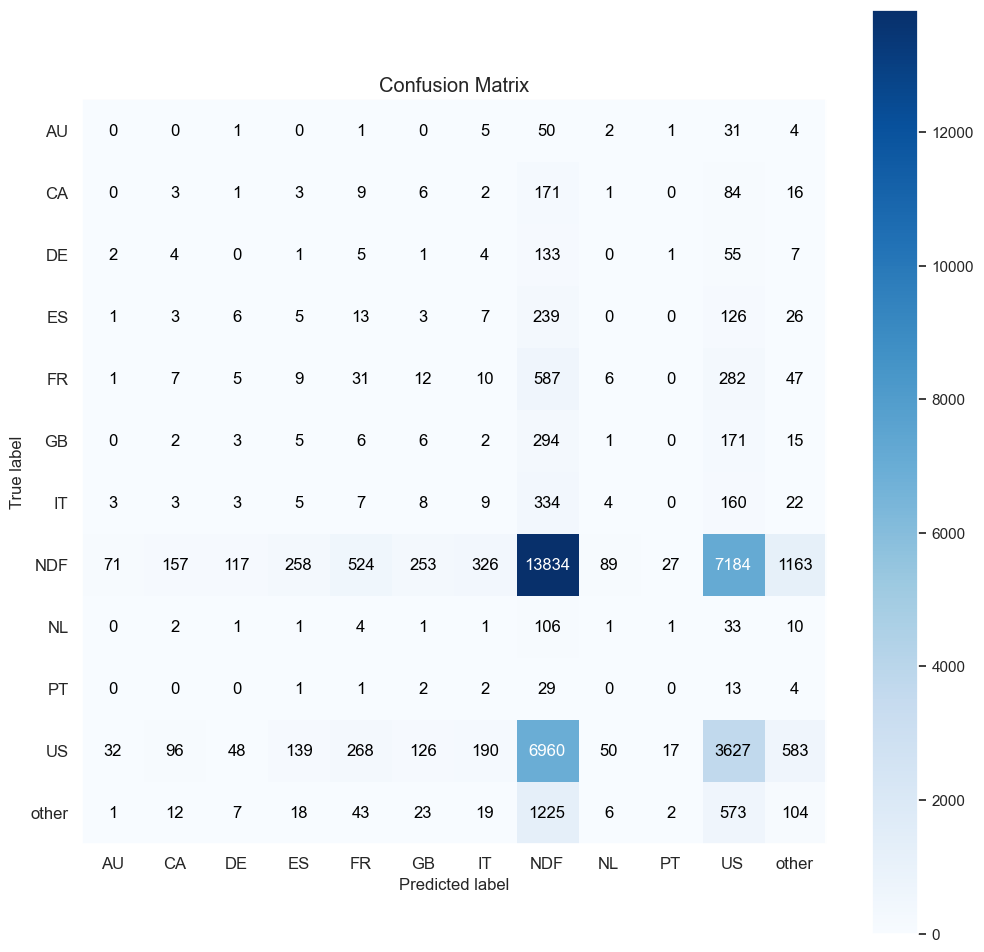

In [83]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )


# Confusion Matrix
balance_acc_random = m.balanced_accuracy_score( y_test, yhat_random)
print( 'Balance Accuracy: {}'.format( balance_acc_random ) )


# kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# classification report
print(m.classification_report( y_test, yhat_random ))

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12, 12) )




## 6.3 Neural Network - MLP

In [84]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [86]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256, input_dim = x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
5185/5185 [==============================] - 8s 1ms/step - loss: 4.7012 - accuracy: 0.7948
Epoch 2/100
5185/5185 [==============================] - 7s 1ms/step - loss: 1.2533 - accuracy: 0.8214
Epoch 3/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.6136 - accuracy: 0.8614
Epoch 4/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.5023 - accuracy: 0.8738
Epoch 5/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4978 - accuracy: 0.8742
Epoch 6/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4965 - accuracy: 0.8743
Epoch 7/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4957 - accuracy: 0.8743
Epoch 8/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4959 - accuracy: 0.8742
Epoch 9/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4939 - accuracy: 0.8743
Epoch 10/100
5185/5185 [==============================] - 7s 1ms/step - l

5185/5185 [==============================] - 7s 1ms/step - loss: 0.4883 - accuracy: 0.8746
Epoch 80/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4880 - accuracy: 0.8747
Epoch 81/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4884 - accuracy: 0.8747
Epoch 82/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4884 - accuracy: 0.8746
Epoch 83/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4877 - accuracy: 0.8747
Epoch 84/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4883 - accuracy: 0.8747
Epoch 85/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4880 - accuracy: 0.8747
Epoch 86/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4880 - accuracy: 0.8747
Epoch 87/100
5185/5185 [==============================] - 7s 1ms/step - loss: 0.4885 - accuracy: 0.8746
Epoch 88/100
5185/5185 [==============================] - 7s 1ms/step - loss:

### 5.2.1 NN Model Performance

In [87]:
# Prediction
pred_nn = model.predict( x_test )

# Invert Prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]


1297/1297 [==============================] - 1s 851us/step


Accuracy: 0.8712811610974492
Balance Accuracy: 0.16666666666666666
Kappa Score: 0.7624435513100608


/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        95
          CA       0.00      0.00      0.00       296
          DE       0.00      0.00      0.00       213
          ES       0.00      0.00      0.00       429
          FR       0.00      0.00      0.00       997
          GB       0.00      0.00      0.00       505
          IT       0.00      0.00      0.00       558
         NDF       1.00      1.00      1.00     24003
          NL       0.00      0.00      0.00       161
          PT       0.00      0.00      0.00        52
          US       0.69      1.00      0.82     12136
       other       0.00      0.00      0.00      2033

    accuracy                           0.87     41478
   macro avg       0.14      0.17      0.15     41478
weighted avg       0.78      0.87      0.82     41478



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

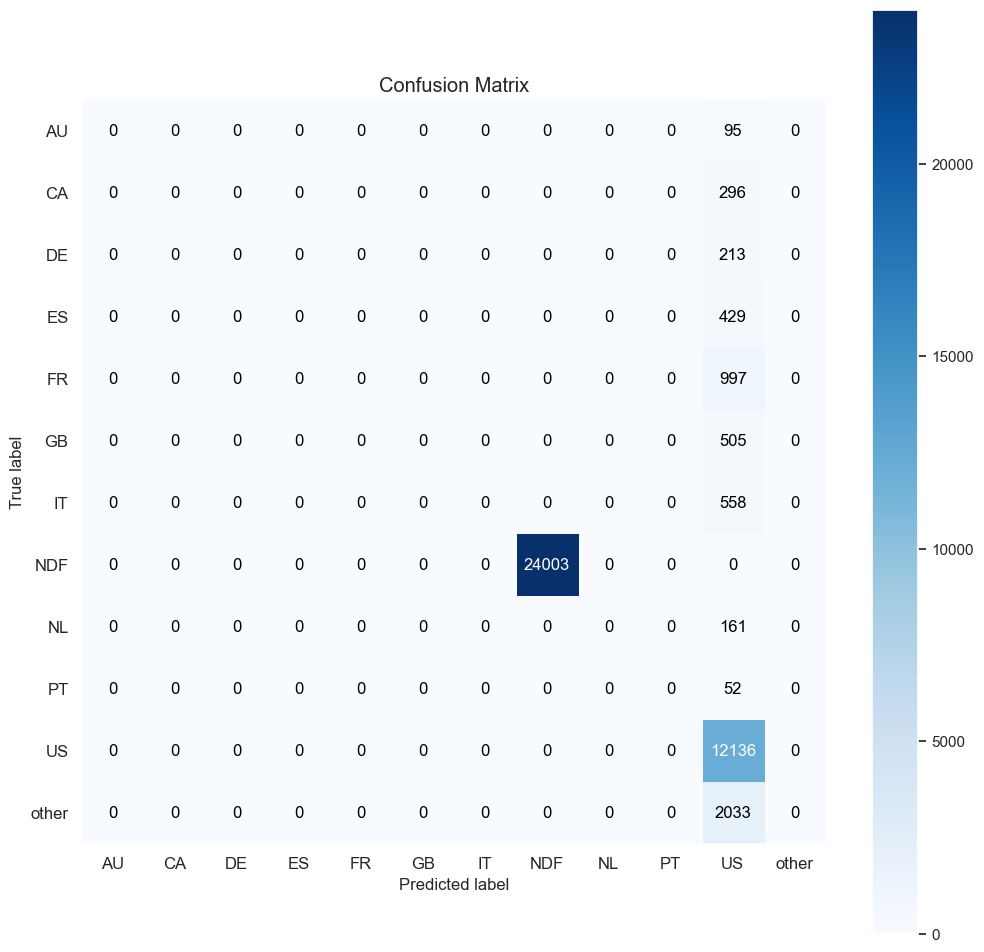

In [88]:

# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )


# Confusion Matrix
balance_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn)
print( 'Balance Accuracy: {}'.format( balance_acc_nn ) )


# kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# classification report
print(m.classification_report( y_test_nn, yhat_nn ))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12, 12) )



### 5.2.3 NN Model Performance - Cross Validation

In [89]:
# gerate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in  kfold.split( x_train, y_train ):
    print( 'fold Number:{}/{}'.format(i, num_folds ) )

    # get fold
    x_train_fold = x_train.iloc[ train_ix ]
    y_train_fold = y_train.iloc[ train_ix ]
    
    x_val_fold =  x_train.iloc[ val_ix ]
    y_val_fold =  y_train.iloc[ val_ix ]
    
    # target
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 )).toarray()


    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax' ) )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )


    # tranning model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )
    
    
    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( -1, 1 )[0]


    # Metrics 



    # Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )

    # kappa metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

fold Number:1/5


ValueError: in user code:

    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/adriele/opt/anaconda3/envs/env_pa001/lib/python3.9/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 12) and (None, 11) are incompatible


In [ ]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ),
                                                  np.round( np.std( balanced_acc_list ),  4 ) ) )

print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 2 ),
                                      np.round( np.std( kappa_acc_list ),  4 ) ) )